In [69]:
import sys
import json
aggregation = {'distance':2000}
constant = {'cst_incline':0}
road_weight = {'residential':0.5,
            'secondary_link':0.3,
            'secondary':0.3,
            'tertiary':0.3,
            'cycleway':1.1,
            'primary':0.3,
            'motorway_link':0,
            'primary_link':0.3,
            'tertiary_link':0.3,
            'motorway':0,
            'trunk':0.2, 
            'trunk_link':0.2  
            }
shared_cycleway_weight = {'residential':0.8,
            'secondary_link':0.5,
            'secondary':0.5,
            'tertiary':0.5,
            'cycleway':1.1,
            'primary':0.5,
            'motorway_link':0,
            'primary_link':0.5,
            'tertiary_link':0.5,
            'motorway':0,
            'trunk':0.4, 
            'trunk_link':0.4   
        }

params = {'aggregation':aggregation,'constant':constant, 'road_weight': road_weight, 'shared_cycleway_weight': shared_cycleway_weight}

         

default = {'training_folder': '../..', 'params':params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../..', 'params': {'aggregation': {'distance': 2000}, 'constant': {'cst_incline': 0}, 'road_weight': {'residential': 0.5, 'secondary_link': 0.3, 'secondary': 0.3, 'tertiary': 0.3, 'cycleway': 1.1, 'primary': 0.3, 'motorway_link': 0, 'primary_link': 0.3, 'tertiary_link': 0.3, 'motorway': 0, 'trunk': 0.2, 'trunk_link': 0.2}, 'shared_cycleway_weight': {'residential': 0.8, 'secondary_link': 0.5, 'secondary': 0.5, 'tertiary': 0.5, 'cycleway': 1.1, 'primary': 0.5, 'motorway_link': 0, 'primary_link': 0.5, 'tertiary_link': 0.5, 'motorway': 0, 'trunk': 0.4, 'trunk_link': 0.4}}}


In [70]:
import os
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from quetzal.engine.road_model import RoadModel
from quetzal.engine.pathfinder_utils import get_path, parallel_dijkstra, build_index, sparse_matrix
from quetzal.engine.msa_utils import get_zone_index, assign_volume
import numpy as np
import random
from shapely.geometry import Point
from typing import Tuple
import time
start = time.time()
num_cores = 1
#from sklearn.cluster import KMeans
from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes
from quetzal.engine.pathfinder_utils import simple_routing,get_path

In [56]:
def drop_duplicated_links(links: gpd.GeoDataFrame,
                          sort_column: str = 'maxspeed', 
                          ascending: bool = False, 
                          return_dropped:bool = False)-> Tuple[gpd.GeoDataFrame,list]:
    '''
    drop duplicated links (a,b) with condition sort_column. if maxspeed and ascending=False, keep faster road
    '''
    before = set(links.index)
    links['dup'] = links['a'] + links['b']
    links = links.sort_values(sort_column, ascending=ascending).drop_duplicates('dup').sort_index()
    links = links.drop(columns='dup')
    after = set(links.index)
    diff = list(before-after)
    print(len(diff), 'links dropped')
    return links, diff

def get_epsg(lat: float, lon: float) -> int:
    '''
    return EPSG in meter for a given (lat,lon)
    lat is north south 
    lon is est west
    '''
      
    return int(32700 - round((45 + lat) / 90, 0) * 100 + round((183 + lon) / 6, 0))

In [71]:
base_folder = argv['training_folder']
road_folder = base_folder + '/inputs/road/'
demand_folder = base_folder +'/inputs/'
output_folder = base_folder +'/outputs/'
print(road_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)


../../inputs/road/


# inputs

In [72]:
cst_incline = argv['params' ]['constant']['cst_incline']
cst_road = argv['params']['road_weight']
cst_shared = argv['params']['shared_cycleway_weight']

In [73]:
#make sure its float
cst_incline = float(cst_incline)
cst_road = {k:float(v) for k,v in cst_road.items()}
cst_shared = {k:float(v) for k,v in cst_shared.items()}

In [74]:
links = gpd.read_file(road_folder + 'road_links.geojson') 
nodes = gpd.read_file(road_folder + 'road_nodes.geojson')
links = links.set_index('index')
nodes = nodes.set_index('index')

In [75]:
demand = pd.read_csv(demand_folder+'demand.csv')
demand = demand.set_index('index')

In [76]:
od_test = pd.read_csv(demand_folder + 'od_test.csv')
od_test = od_test.set_index('index')
assert all([col in od_test.columns for col in ['name','xo','yo','xd','yd'] ]), 'need name, xo, yo, xd, yd in od_test'


In [77]:
assert all([col in demand.columns for col in ['xo','yo','xd','yd','volume'] ]), 'need origin,destination and volume in demand'


# agg demand

format demand and create zone

In [78]:
demand['origin'] = [*zip(demand['xo'],demand['yo'])]
demand['destination'] = [*zip(demand['xd'],demand['yd'])]
demand = demand.drop(columns=['xo','yo','xd','yd'])

In [79]:
# get unique zones
zones_set = set(demand['origin'].values).union(set(demand['destination'].values))
zones_dict = {val:'zone_'+str(i) for i,val in enumerate(zones_set)}
zones_df = [{'index':zone,'geometry':Point(val)} for val,zone in zones_dict.items()]

In [80]:
demand['origin'] = demand['origin'].apply(lambda x: zones_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: zones_dict.get(x))
zones = gpd.GeoDataFrame(zones_df,crs=4326).set_index('index')

Clustering

In [81]:
agg_dist = float(argv['params']['aggregation']['distance'])
epsg = get_epsg(zones.iloc[0]['geometry'].y, zones.iloc[0]['geometry'].x)
label = agglomerative_clustering(zones.to_crs(epsg), distance_threshold = agg_dist)
zones['cluster'] = label

In [82]:
print(len(zones),'zones agg to',len(zones['cluster'].unique()),' zones')

14479 zones agg to 697  zones


In [83]:
# create a dict zone:cluster
zones['cluster'] = 'zone_' + zones['cluster'].astype(str)
cluster_dict = zones['cluster'].to_dict()

In [84]:
# drop duplicated cluster and rename index with new cluster as zones_id
zones = zones.drop_duplicates('cluster')
zones = zones.set_index('cluster')
zones.index.name='index'

 AGG demand on new zones (volime is sum)

In [85]:
# apply new cluster fict to the demand
demand['origin'] = demand['origin'].apply(lambda x: cluster_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: cluster_dict.get(x))

In [86]:
demand = demand.groupby(['origin','destination']).agg(sum).reset_index()
demand.index.name = 'index'

# export zones and demand in outputs

<Axes: >

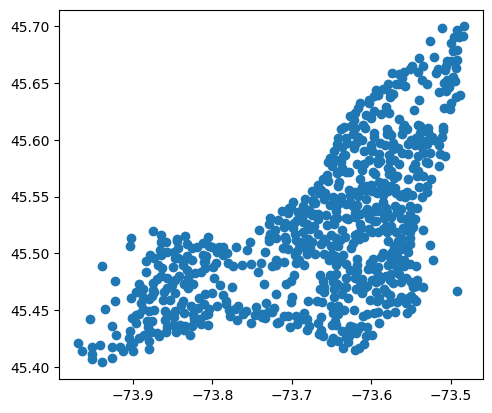

In [87]:
zones.plot()

In [88]:
#zones.to_file(output_folder + 'centroids.geojson',driver='GeoJSON')

In [89]:
# Group the DataFrame by "origin" and "destination", and then convert to JSON
grouped = demand.groupby(["origin", "destination"])["volume"].sum().reset_index()
json_data = {}
for _, row in grouped.iterrows():
    origin = row["origin"]
    destination = row["destination"]
    volume = row["volume"]
    if origin not in json_data:
        json_data[origin] = {}
    json_data[origin][destination] = volume

    
with open(output_folder + 'zones.json', 'w') as json_file:
    json.dump({'volume':json_data},json_file)

In [90]:
convex_hull = zones.unary_union.convex_hull.buffer(1e-3)
voronoi = voronoi_diagram_dataframes(zones['geometry'])
voronoi = gpd.GeoDataFrame(voronoi[0],crs=4326)
voronoi = voronoi.clip(convex_hull)
voronoi.to_file(output_folder + 'zones.geojson',driver='GeoJSON')

/home/boivin/.pyenv/versions/3.8.6/envs/quetzal_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [91]:
'''
def create_zones_from_nodes(nodes,num_zones=200):
    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)
    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)
    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')
    cluster.fit(nodes[['x','y']].values)
    geom = [Point(val) for val in cluster.cluster_centers_]
    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)
    zones.index = 'zone_' + zones.index.astype(str)
    return zones
#create_zones_from_nodes(zones).plot()
'''

"\ndef create_zones_from_nodes(nodes,num_zones=200):\n    nodes['x'] = nodes['geometry'].apply(lambda p:p.x)\n    nodes['y'] = nodes['geometry'].apply(lambda p:p.y)\n    cluster = KMeans(n_clusters=num_zones,random_state=0,n_init='auto')\n    cluster.fit(nodes[['x','y']].values)\n    geom = [Point(val) for val in cluster.cluster_centers_]\n    zones = gpd.GeoDataFrame(range(len(geom)),geometry=geom,crs=4326).drop(columns=0)\n    zones.index = 'zone_' + zones.index.astype(str)\n    return zones\n#create_zones_from_nodes(zones).plot()\n"

# split oneway quenedi links

In [92]:
links['incline'] = links['incline'].astype(float)

In [93]:
# split quenedi road links
self = RoadModel(links,nodes,zones,ff_time_col='time')

In [94]:

print('split rlinks to oneways')
self.split_quenedi_rlinks()
self.zones_nearest_node()

split rlinks to oneways


../../../quetzal/quetzal/engine/road_model.py:129: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid['geometry'] = centroid.centroid


max_distance found:  0.0 degrees


In [95]:
zones = self.zones_centroid

In [96]:
links = self.road_links
del self

# tag cycleways

In [97]:

index = [idx for idx in links.index if not idx.endswith('_r')]
index_r = [idx for idx in links.index if idx.endswith('_r')]
assert len(index)+len(index_r) == len(links)

links['isroad'] = True
ls = links.loc[index].loc[links['cycleway'].isin(['yes','shared'])].index
links.loc[ls,'isroad'] = False
ls = links.loc[index_r].loc[links['cycleway_reverse'].isin(['yes','shared'])].index
links.loc[ls,'isroad'] = False


In [98]:
len(links[~links['isroad']])

18540

# apply Weight

In [99]:
# incline weigth (starting point)
links['eff_speed'] = 20  * (1 - cst_incline * np.sin(np.deg2rad(links['incline'])))


In [100]:
# derate it with road weight
links['cst_road'] = links['highway'].apply(lambda x: cst_road.get(x,1))
links.loc[links['isroad'],'eff_speed'] = links.loc[links['isroad'],'eff_speed'] * links.loc[links['isroad'],'cst_road']

In [101]:
# derate it with shared cycleway weight
links['cst_shared'] = links['highway'].apply(lambda x: cst_shared.get(x,1))

ls = links.loc[index].loc[links['cycleway']=='shared'].index
links.loc[ls,'eff_speed'] = links.loc[ls,'eff_speed'] * links.loc[ls,'cst_shared']

ls = links.loc[index_r].loc[links['cycleway_reverse']=='shared'].index
links.loc[ls,'eff_speed'] = links.loc[ls,'eff_speed'] * links.loc[ls,'cst_shared']

transform effective speed to a weight

In [102]:
# anything with neg speed round to 0. (dijkstra need positive weight)
links['eff_speed'] = links['eff_speed'].apply(lambda x : max(x,0))

In [103]:
links['weight'] = links['length']/(links['eff_speed']*1000/3600)

In [104]:
links = links.drop(columns=['cst_road','cst_shared'])

# Shortest path + volume assignment

In [105]:
zones_nodes_dict = zones['node_index'].to_dict()
demand['o_zone'] = demand['origin']
demand['d_zone'] = demand['destination']
demand['origin'] = demand['origin'].apply(lambda x: zones_nodes_dict.get(x))
demand['destination'] = demand['destination'].apply(lambda x: zones_nodes_dict.get(x))

In [106]:
df = links[['a', 'b','weight']].copy()

In [107]:
df, dropped = drop_duplicated_links(df,sort_column='weight',ascending=False)

920 links dropped


In [108]:
edges = df[['a', 'b', 'weight']].values  # to build the index once and for all
index = build_index(edges)
reversed_index = {v: k for k, v in index.items()}
# apply sparse index on zones
demand, zones_indices = get_zone_index(df, demand, index)

In [109]:
# apply sparse index on links
df['sparse_a'] = df['a'].apply(lambda x: index.get(x))
df['sparse_b'] = df['b'].apply(lambda x: index.get(x))
volumes_sparse_keys = list(zip(df['sparse_a'],df['sparse_b']))

odv = demand[['o', 'd', 'volume']].values

In [110]:
edges = df[['a', 'b', 'weight']].values
sparse, _ = sparse_matrix(edges, index=index)
time_matrix, predecessors = parallel_dijkstra(sparse,
                                              directed=True,
                                              indices=zones_indices,
                                              return_predecessors=True,
                                              num_core=num_cores,
                                              keep_running=True)

# this give OD_time/time_matrix on each links. then X links time for the ratio links_time/tot_time


In [111]:
ab_volumes = assign_volume(odv,predecessors,volumes_sparse_keys,reversed_index)

restrict links to df.index (dropped duplicated links). if not. volume will not be assign on the right link (when duplicated) or, maybe on both.

In [112]:
links['volume'] = 0
links.loc[df.index,'volume'] = links.loc[df.index].set_index(['a', 'b']).index.map(ab_volumes.get)

# cleaning and exporting

In [113]:
col_r = [col for col in links.columns if col.endswith('_r')]
links = links.drop(columns=col_r)
links = links.drop(columns=['isroad'])


In [114]:
links.to_file(output_folder + 'loaded_links.geojson',driver='GeoJSON')

In [115]:
links['volume'].sum()

83315907

In [116]:
print(time.time()-start)

82.19191575050354


# OD test

In [117]:
od_test['geometry_o'] = [Point(val) for val in od_test[['xo','yo']].values]
od_test['geometry_d'] = [Point(val) for val in od_test[['xd','yd']].values]

/home/boivin/.pyenv/versions/3.8.6/envs/quetzal_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/home/boivin/.pyenv/versions/3.8.6/envs/quetzal_env/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [118]:
# find nearest node with KNN. nodes are now the origin and destination.
od_test['geometry'] = od_test['geometry_o']
neigh = nearest(od_test, nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
od_test['origin'] = od_test.index.map(zone_node_dict.get)

od_test['geometry'] = od_test['geometry_d']
neigh = nearest(od_test, nodes, n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
od_test['destination'] = od_test.index.map(zone_node_dict.get)

od_test = od_test.drop(columns=['xo','xd','yo','yd','geometry_o','geometry_d','geometry'])

In [119]:
o_nodes = od_test['origin'].values
d_nodes = od_test['destination'].values

time_mat, predecessors, node_index = simple_routing(o_nodes,d_nodes,links,weight_col='weight',return_predecessors=True)
reversed_index = {v: k for k, v in node_index.items()}

routes = gpd.GeoDataFrame()
for o,d in  enumerate(od_test['destination'].values):
    path = get_path(predecessors, o, node_index[d])
    path = list(zip(path[:-1], path[1:]))

    path = [(reversed_index[k[0]], reversed_index[k[1]]) for k in path]
    links_dict = links.reset_index().set_index(['a','b'])['index'].to_dict()
    path = [*map(links_dict.get,path)]

    route = links.loc[path]
    route['od_name'] =  od_test.iloc[o]['name']
    routes = pd.concat([routes,route])

In [120]:
routes.to_file(output_folder + 'od_routes.geojson',driver='GeoJSON')

In [121]:
print(time.time()-start)

92.36314678192139


# end

# merging

In [218]:
'''
def merge_quenedi_rlinks(road_links,new_col):
    if 'oneway' not in road_links.columns:
        print('no column oneway. do not merge')
        return
    #get reversed links
    index_r = [idx for idx in road_links.index if idx.endswith('_r')]
    if len(index_r) == 0:
        print('all oneway, nothing to merge')
        return
    links_r = road_links.loc[index_r].copy()
    # create new reversed column with here speed and time
    links_r[new_col + '_r'] = links_r[new_col]
    # reindex with initial non _r index to merge
    links_r.index = links_r.index.map(lambda x: x[:-2])
    links_r = links_r[[new_col + '_r']]
    # drop added _r links, merge new here columns to inital two way links.
    road_links = road_links.drop(index_r, axis=0)
    # drop column if they exist before merge. dont want duplicates
    if new_col + '_r' in road_links.columns:
        road_links = road_links.drop(columns=new_col + '_r')
    road_links = pd.merge(road_links, links_r, left_index=True, right_index
                                =True, how='left')
    return road_links
'''

"\ndef merge_quenedi_rlinks(road_links,new_col):\n    if 'oneway' not in road_links.columns:\n        print('no column oneway. do not merge')\n        return\n    #get reversed links\n    index_r = [idx for idx in road_links.index if idx.endswith('_r')]\n    if len(index_r) == 0:\n        print('all oneway, nothing to merge')\n        return\n    links_r = road_links.loc[index_r].copy()\n    # create new reversed column with here speed and time\n    links_r[new_col + '_r'] = links_r[new_col]\n    # reindex with initial non _r index to merge\n    links_r.index = links_r.index.map(lambda x: x[:-2])\n    links_r = links_r[[new_col + '_r']]\n    # drop added _r links, merge new here columns to inital two way links.\n    road_links = road_links.drop(index_r, axis=0)\n    # drop column if they exist before merge. dont want duplicates\n    if new_col + '_r' in road_links.columns:\n        road_links = road_links.drop(columns=new_col + '_r')\n    road_links = pd.merge(road_links, links_r, left

In [219]:
#links = merge_quenedi_rlinks(links,'volume')

# test